In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1"

# MNIST: VAE 

In [3]:
import jax
import optax
import distrax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.training import train_state
from torchvision.datasets import MNIST

import vae
import linear_factor as lf_demo

2022-09-26 08:27:37.225519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-26 08:27:37.249300: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-26 08:27:37.902828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-26 08:27:37.902945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


## Create train dataset

In [6]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [215]:
key = jax.random.PRNGKey(314)
key_fa_param, key_sample, key = jax.random.split(key, 3)
key_vae, key_test = jax.random.split(key)

In [47]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

# VAE

In [48]:
class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_full)(x)
        logvar_x = nn.Dense(self.dim_full)(x)
        return mean_x, logvar_x
    

class EncoderFullCov(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5

    def setup(self):
        init_tri = nn.initializers.normal(stddev=1e-5)
        # Number of elments in the lower (without diagonal) triangular matrix
        tril_dim = self.latent_dim * (self.latent_dim + 1) // 2 - self.latent_dim
        self.hidden_layer = nn.Dense(self.n_hidden, name="latent_hidden")
        self.mean_layer = nn.Dense(self.latent_dim, name="latent_mean")
        self.logvardiag_layer = nn.Dense(self.latent_dim, use_bias=False, name="latent_logvardiag", kernel_init=init_tri)
        self.tril_layer  = nn.Dense(tril_dim, name="latent_tril", use_bias=False, kernel_init=init_tri)


    @nn.compact
    def __call__(self, x):
        z = self.hidden_layer(x)
        z = nn.relu(z)

        mean_z = self.mean_layer(z)
        logvar_z = self.logvardiag_layer(z)
        diag_z = jax.vmap(jnp.diag)(jnp.exp(logvar_z / 2))
        Lz = self.tril_layer(z)
        Lz = jax.vmap(vae.fill_lower_tri, (0, None))(Lz, self.latent_dim)

        return mean_z, Lz + diag_z
    

    
class VAEIWFD(nn.Module):
    """
    Importance-Weighted Variational Autoencoder with Full Covariance Matrix
    for the posterior distribution
    """
    latent_dim: int
    full_dim: int
    n_hidden: int = 5
    
    def reparameterise(self, key, mean, cov, num_samples):
        num_obs = len(mean)
        eps = jax.random.normal(key, (num_samples, num_obs, self.latent_dim))
        z = mean + jnp.einsum("...dm,...m->...d", cov, eps)
        return z
    
    def setup(self):
        self.encoder = EncoderFullCov(self.latent_dim, self.n_hidden)
        self.decoder = Decoder(self.full_dim)
    
    def __call__(self, x, key_eps, num_samples=1):
        mean_z, L_z = self.encoder(x)
        z = self.reparameterise(key_eps, mean_z, L_z, num_samples)
        mean_x, logvar_x = self.decoder(z)
        return z, (mean_z, L_z), (mean_x, logvar_x)

## Full covariance matrix

In [160]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [161]:
batch_size = 100
n_epochs = 4000

In [162]:
tx = optax.adam(1e-5)

In [163]:
n_hidden = 100
batch_init = jnp.ones((batch_size, dim_obs))

dim_latent = 50
model = vae.VAEIW(dim_latent, dim_obs, n_hidden)
params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)

In [164]:
z, (mean_z, L_z), (mean_x, logvar_x) = model.apply(params_init, X_train[:1], key_train)

In [165]:
state = train_state.TrainState.create(
    apply_fn=partial(model.apply, num_samples=13),
    params=params_init,
    tx=tx
)

In [166]:
train_step = partial(vae.train_step,
                     model=model,
                     loss_fn=partial(vae.iwae, num_is_samples=13))
train_step = jax.jit(train_step)


def train_epoch(key, state, X, batch_size):
    num_samples = len(X)
    key_batch, keys_vae = jax.random.split(key)
    batch_ixs = vae.get_batch_train_ixs(key_batch, num_samples, batch_size)
    
    num_batches = len(batch_ixs)
    keys_vae = jax.random.split(keys_vae, num_batches)
    
    total_loss = 0
    for key_vae, batch_ix in zip(keys_vae, batch_ixs):
        X_batch = X[batch_ix, ...]
        loss, state = train_step(state, X_batch, key_vae)
        total_loss += loss
    
    return total_loss.item(), state

In [174]:
keys_train = jax.random.split(key_train, n_epochs)
hist_loss = []
hist_mll_vae_iw_full = []
for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = train_epoch(keyt, state, X_train, batch_size)
    
    hist_loss.append(loss)
    
    pbar.set_description(f"{loss=:0.4e}")
params_final = state.params

  0%|          | 0/4000 [00:00<?, ?it/s]

In [213]:
hist_mll = -jnp.array(hist_loss)
hist_mll[-1]

DeviceArray(-498403.03, dtype=float32)

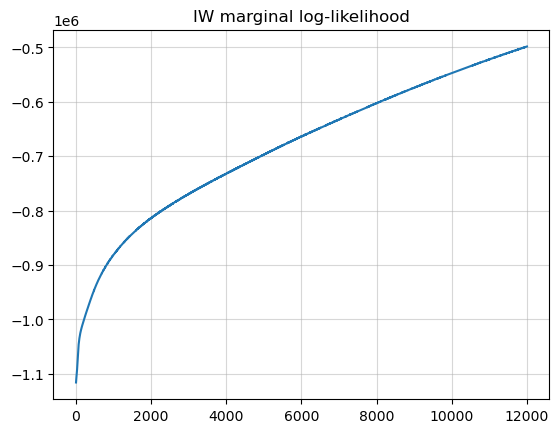

In [184]:
plt.title("IW marginal log-likelihood")
plt.plot(hist_mll)
plt.grid(alpha=0.5)

In [236]:
n_samples = 5
key_samples, _ = jax.random.split(key_test)
key_samples = jax.random.split(key_samples, n_samples)

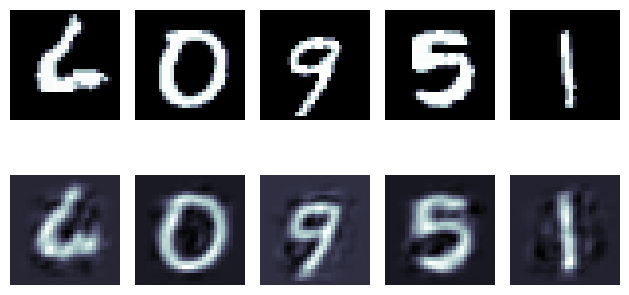

In [239]:
ixs_test = jax.random.choice(key_test, len(X_train), (n_samples,))
ixs_test = jnp.array([598, 458, 183, 620,   8])

fig, ax = plt.subplots(2, n_samples, figsize=(6.4, 4.0))

for ax, ix in zip(ax.T, ixs_test):
    obs = X_train[ix]
    z, (mean_z, L_z), (mean_x, logvar_x) = model.apply(params_final, obs, key_train)

    ax[0].imshow(obs.reshape(28, 28), cmap="bone")
    ax[1].imshow(mean_x.reshape(28, 28), cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
plt.tight_layout()